## Setting everything up

In [1]:
import os
#import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy.stats
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from fbprophet import Prophet

## Functions for executions

In [58]:
#one function for all calculations
def ribbon_stats(locdict,filepath,var):

    # read data
    dataall=xr.load_dataset(filepath)
    
    # drop year 2100 with all zeros 
    dataall=dataall.sel(time=(dataall['time.year']!=2100))
    
    # loop through dictionary
    slist=[]
    for place,location in locdict.items():
        
        print(place)
        
        select=dataall.sel(lon=location[0],lat=location[1],method='nearest')
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[select['month'].isin([1,2,12])]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdf=(
            select
            .groupby(['winter'],as_index=False)[var]
            .agg(['mean','std','skew'])
            .rename({'mean':f'mean_{var}','std':f'std_{var}','skew':f'skew_{var}'})
            .reset_index(drop=False)
        )
        sdf['name']=place
        slist.append(sdf)
        
    df=pd.concat(slist)   
    dfmelt=pd.melt(df,id_vars=['winter','name'])
    
    return dfmelt

In [59]:
# summarize by five-years
def ribbon_stats_summarize(locdict,filepath,startyr,var):
    dfmelt = ribbon_stats(locdict,filepath,var)
    dfmelt['decade']=(np.floor((dfmelt['winter']-startyr)/5)+1)*5+(startyr-5)
    
    dfsum=(
            dfmelt
            .groupby(['decade','variable','name'],as_index=False)['value']
            .agg(['mean','min','max'])
            .reset_index(drop=False)
        )
    dfsum['decade'] = dfsum['decade'].astype(int)
    
    return dfmelt,dfsum

## Output csv files for Ivan

In [57]:
# dictionary of all locations
names={'Chicago':(-87.5,42),
       'Hohhot':(111.75,41),
       'Barent':(40.5,75),
       'Pacific':(179.5,41.5),
       'Greenland':(-42.5,71.75),
       'Maine':(-69.5, 45.25),
       'Washington':(-120.75, 47.75), 
       'British Columbia':(-123.0, 54.0)
      }

In [60]:
# list of paths and variables
plist=['era5_1950_1979','era5_1979_2021','CESM2','MPI','GFDL','IPSL']
vlist=['phi_eq_prime','dm_t_prime']

for var in vlist: 
    print(var)
    
    for period in plist:
        print(period)
        
        # define
        if var=='phi_eq_prime':
            vartag='eff_lat_demeaned_shifted'
        else:
            vartag='t_prime_demeaned'
            
        # period start
        if period=='era5_1950_1979':
            startyr=1950
        elif period=='era5_1979_2021':
            startyr=1980
        else:
            startyr=2015
        
        # path
        if (period=='era5_1950_1979') | (period=='era5_1979_2021'):
            path='/project2/moyer/jetstream/era5_processed_data/post_processing_output/'+period+'_'+vartag+'.nc4'
        else: 
            path='/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+period+'_'+vartag+'.nc4'
            
        # get dataframes
        dfmelt,dfsum=ribbon_stats_summarize(names,path,startyr,var)
        
        # output
        dfmelt.to_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_'+period+'_ribbon_dfmelt.csv',index=True)
        dfsum.to_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_'+period+'_ribbon_dfsum.csv',index=True)
        

phi_eq_prime
era5_1950_1979
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
era5_1979_2021
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
CESM2
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
MPI
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
GFDL
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
IPSL
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
dm_t_prime
era5_1950_1979
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
era5_1979_2021
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
CESM2
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
MPI
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
GFDL
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
British Columbia
IPSL
Chicago
Hohhot
Barent
Pacific
Greenland
Maine
Washington
Briti

In [61]:
ls -l /project2/moyer/jetstream/ribbon_files

total 2496
-rw-rw-r-- 1 yuqisong pi-moyer 101312 Jun 19 18:47 dm_t_prime_CESM2_ribbon_dfmelt.csv
-rw-rw-r-- 1 yuqisong pi-moyer  32856 Jun 19 18:47 dm_t_prime_CESM2_ribbon_dfsum.csv
-rw-rw-r-- 1 yuqisong pi-moyer   6473 Jun 18 14:15 dm_t_prime_Chicago_sddf1.csv
-rw-rw-r-- 1 yuqisong pi-moyer   6435 Jun 18 14:15 dm_t_prime_Chicago_sddf2.csv
-rw-rw-r-- 1 yuqisong pi-moyer   6461 Jun 18 14:15 dm_t_prime_Chicago_sddf3.csv
-rw-rw-r-- 1 yuqisong pi-moyer   6481 Jun 18 14:15 dm_t_prime_Chicago_sddf4.csv
-rw-rw-r-- 1 yuqisong pi-moyer   1920 Jun 18 14:15 dm_t_prime_Chicago_sddf_pre1.csv
-rw-rw-r-- 1 yuqisong pi-moyer   3225 Jun 18 14:15 dm_t_prime_Chicago_sddf_pre2.csv
-rw-rw-r-- 1 yuqisong pi-moyer   1088 Jun 18 14:15 dm_t_prime_Chicago_sdsum1.csv
-rw-rw-r-- 1 yuqisong pi-moyer   1063 Jun 18 14:15 dm_t_prime_Chicago_sdsum2.csv
-rw-rw-r-- 1 yuqisong pi-moyer   1080 Jun 18 14:15 dm_t_prime_Chicago_sdsum3.csv
-rw-rw-r-- 1 yuqisong pi-moyer   1084 Jun 18 14:15 dm_t_prime_Chicago_sdsum4.csv
-rw-rw

## Plot Banquets 3 by 2

In [69]:
# plot either variable
def ribbon_subplot(city,var,stat,ax):
    
    ax=ax
    
    # labels
    if stat=="mean":
        lab1="Mean"
    elif stat=="std":
        lab1="STD"
    else:
        lab1="Skewness"
        
    if var=="phi_eq_prime":
        ylab="Deg"
        lab2="demean-shifted eff. lat."
    else: 
        ylab="K"
        lab2="demeaned T-prime"
    
    # read files
    pre1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_era5_1950_1979_ribbon_dfsum.csv')
    pre1=pre1[pre1['decade']!=1975]
    pre2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_era5_1979_2021_ribbon_dfsum.csv')
    pre2=pre2[pre2['decade']!=1975]
    mod1=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_CESM2_ribbon_dfsum.csv')
    mod2=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_MPI_ribbon_dfsum.csv')
    mod3=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_GFDL_ribbon_dfsum.csv')
    mod4=pd.read_csv('/project2/moyer/jetstream/ribbon_files/'+var+'_IPSL_ribbon_dfsum.csv')
    
    # select
    pre1=pre1[(pre1['name']==city) & (pre1['variable']==stat)]
    pre2=pre2[(pre2['name']==city) & (pre2['variable']==stat)]
    mod1=mod1[(mod1['name']==city) & (mod1['variable']==stat)]
    mod2=mod2[(mod2['name']==city) & (mod2['variable']==stat)]
    mod3=mod3[(mod3['name']==city) & (mod3['variable']==stat)]
    mod4=mod4[(mod1['name']==city) & (mod4['variable']==stat)]
    
    # plotting
    ax.plot(pre1.decade, pre1['mean'], label="_nolegend_", color="black")
    ax.fill_between(pre1.decade, pre1['min'], pre1['max'], alpha=0.1, color="black")
    ax.plot(pre2.decade, pre2['mean'], label='_nolegend_', color="black")
    ax.fill_between(pre2.decade, pre2['min'], pre2['max'], alpha=0.1, color="black")

    ax.plot(mod1.decade, mod1['mean'], label="_nolegend_", color="red")
    ax.fill_between(mod1.decade, mod1['min'], mod1['max'], alpha=0.1, color="red")

    ax.plot(mod2.decade, mod2['mean'], label="_nolegend_", color="blue")
    ax.fill_between(mod2.decade, mod2['min'], mod2['max'], alpha=0.1, color="blue")

    ax.plot(mod3.decade, mod3['mean'], label="_nolegend_", color="orange")
    ax.fill_between(mod3.decade, mod3['min'], mod3['max'], alpha=0.1, color="orange")

    ax.plot(mod4.decade, mod4['mean'], label="_nolegend_", color="green")
    ax.fill_between(mod4.decade, mod4['min'], mod4['max'], alpha=0.1, color="green")

    ax.axvline(x=2015)
    ax.set_xlim(1950, 2095)
    
    ax.set_ylabel(ylab)
    ax.set_xlabel('year')
    ax.set_facecolor('white')
    ax.set_title(lab1+' of '+lab2) 
    

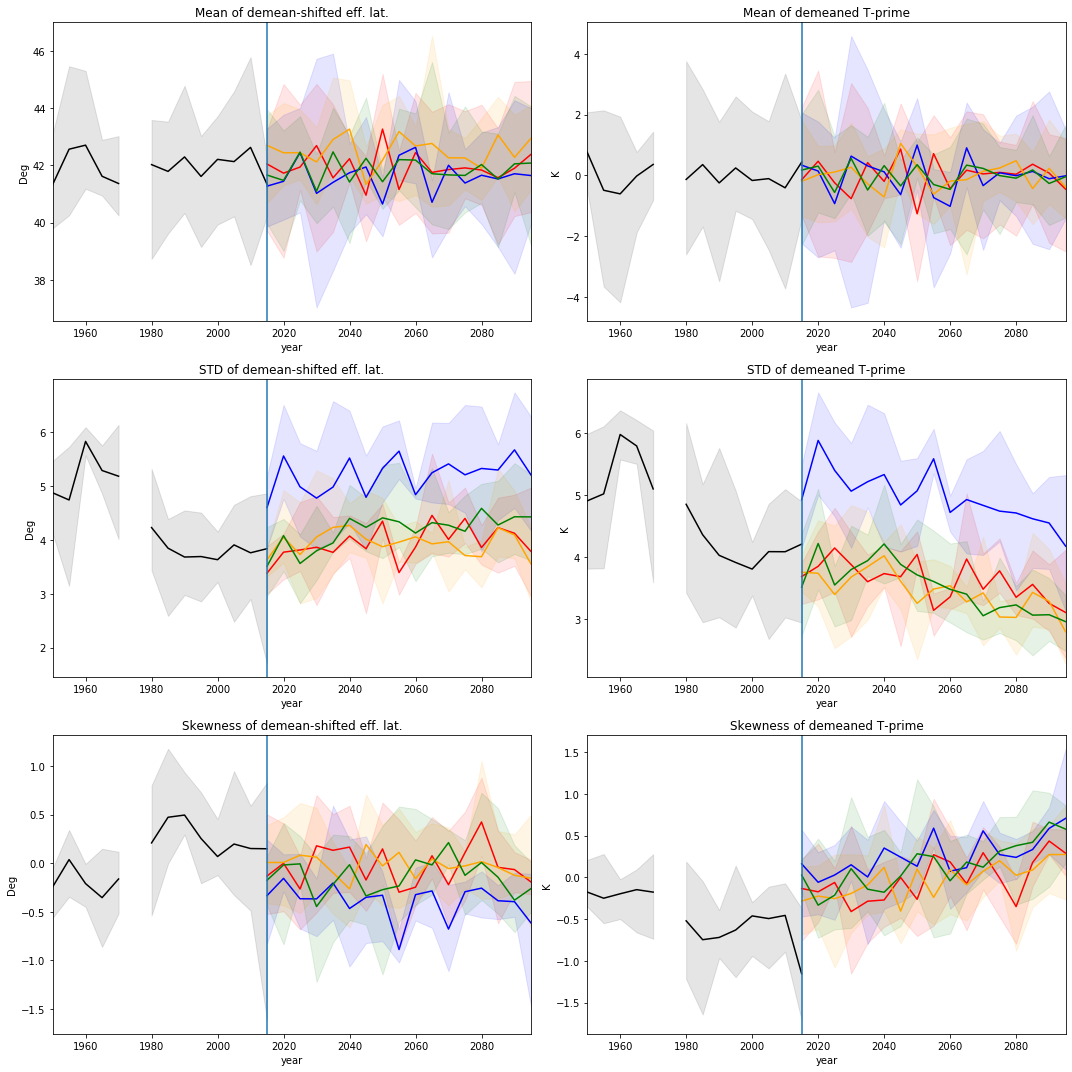

In [70]:
# Chicago: 42N, 87.5W
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Chicago','phi_eq_prime','mean',ax1)
ribbon_subplot('Chicago','dm_t_prime','mean',ax2)
ribbon_subplot('Chicago','phi_eq_prime','std',ax3)
ribbon_subplot('Chicago','dm_t_prime','std',ax4)
ribbon_subplot('Chicago','phi_eq_prime','skew',ax5)
ribbon_subplot('Chicago','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

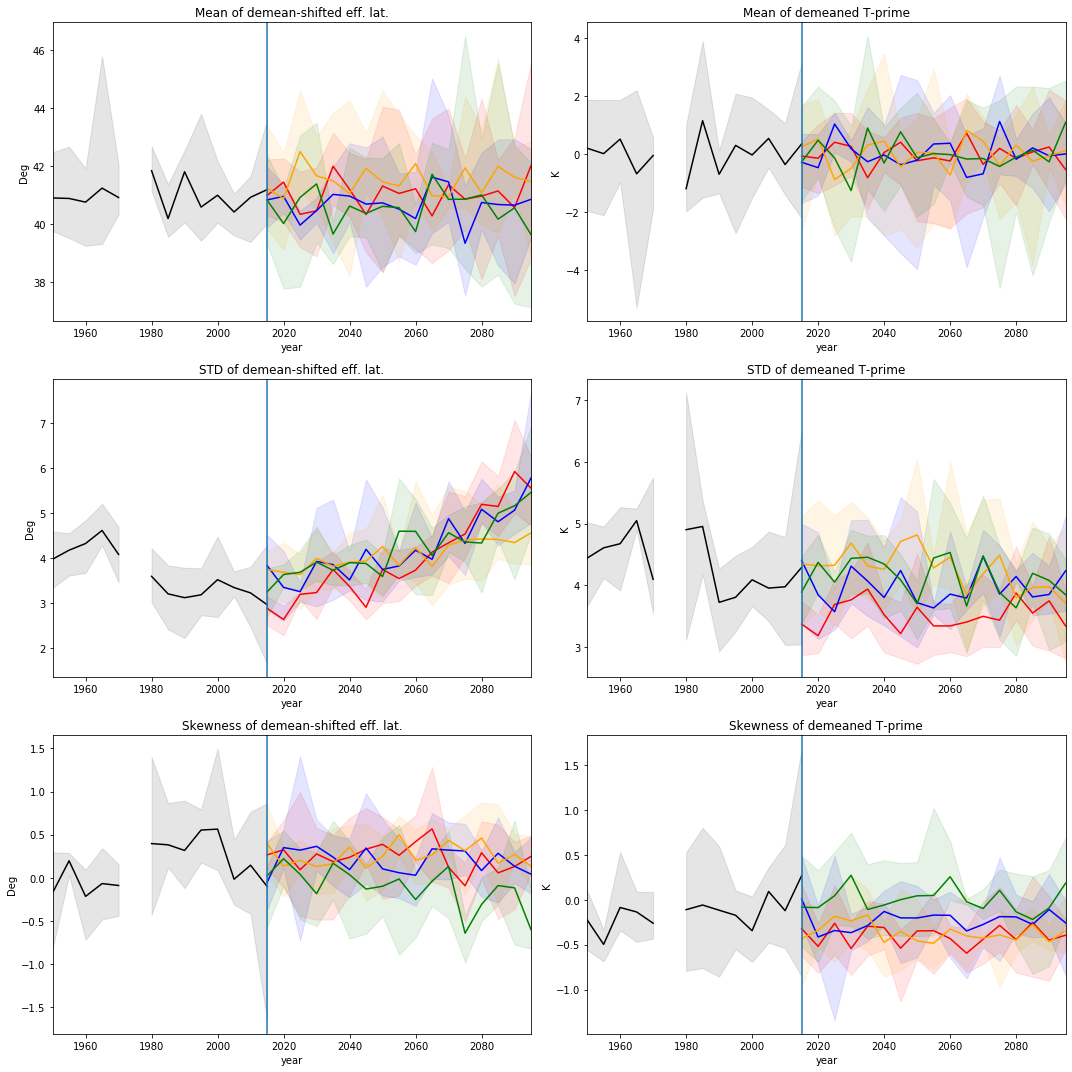

In [71]:
# Hohhot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Hohhot','phi_eq_prime','mean',ax1)
ribbon_subplot('Hohhot','dm_t_prime','mean',ax2)
ribbon_subplot('Hohhot','phi_eq_prime','std',ax3)
ribbon_subplot('Hohhot','dm_t_prime','std',ax4)
ribbon_subplot('Hohhot','phi_eq_prime','skew',ax5)
ribbon_subplot('Hohhot','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

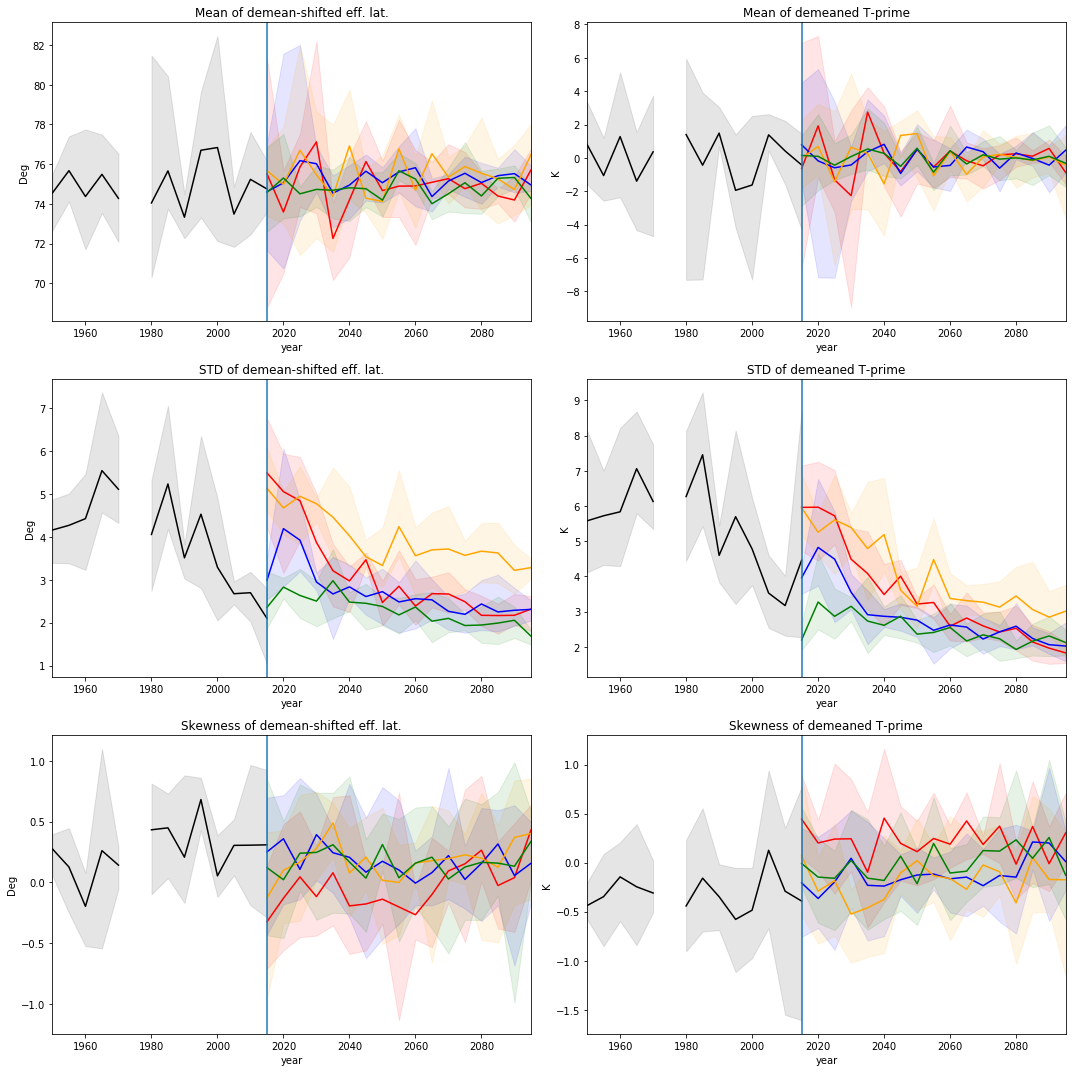

In [72]:
# Barent
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Barent','phi_eq_prime','mean',ax1)
ribbon_subplot('Barent','dm_t_prime','mean',ax2)
ribbon_subplot('Barent','phi_eq_prime','std',ax3)
ribbon_subplot('Barent','dm_t_prime','std',ax4)
ribbon_subplot('Barent','phi_eq_prime','skew',ax5)
ribbon_subplot('Barent','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

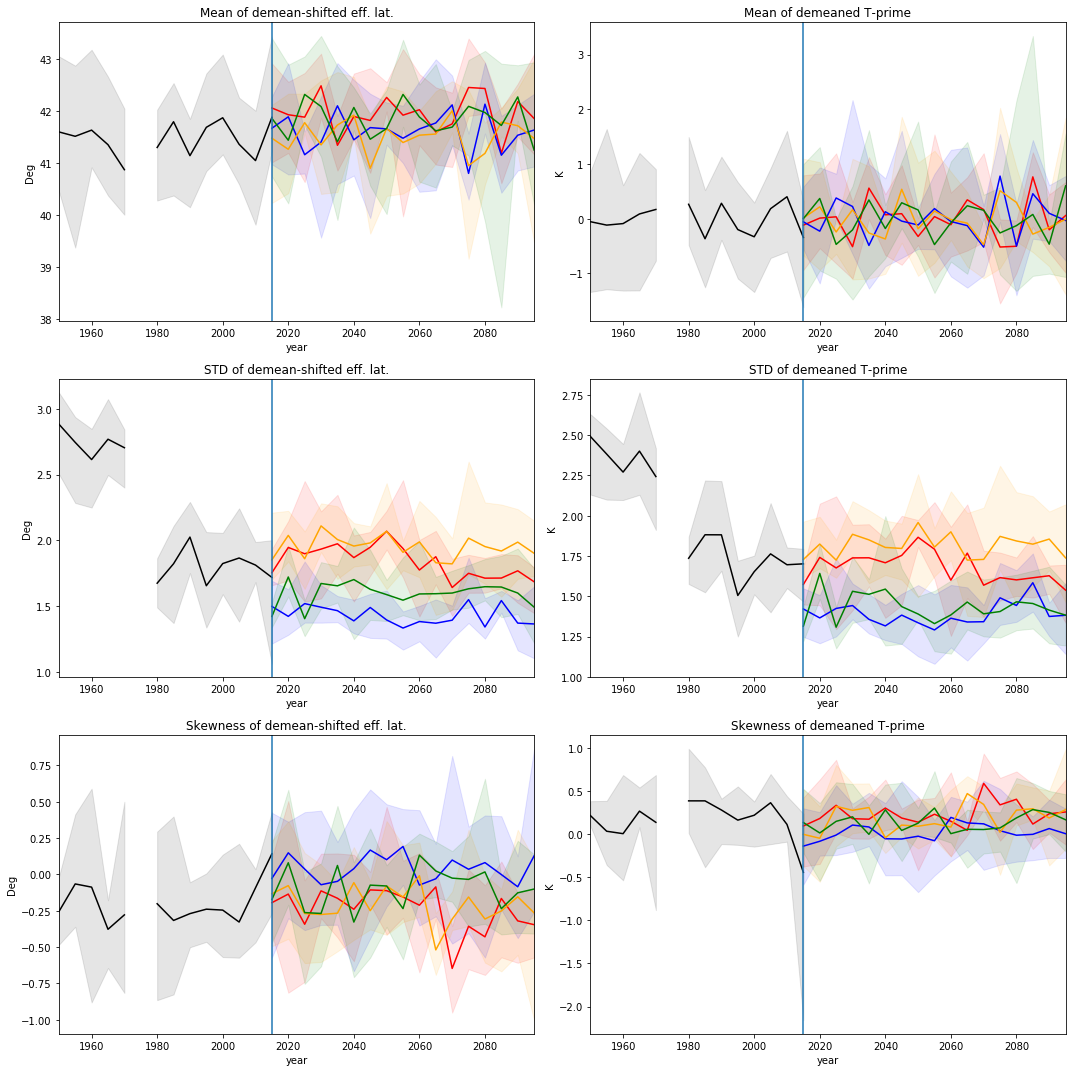

In [73]:
# Pacific
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Pacific','phi_eq_prime','mean',ax1)
ribbon_subplot('Pacific','dm_t_prime','mean',ax2)
ribbon_subplot('Pacific','phi_eq_prime','std',ax3)
ribbon_subplot('Pacific','dm_t_prime','std',ax4)
ribbon_subplot('Pacific','phi_eq_prime','skew',ax5)
ribbon_subplot('Pacific','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

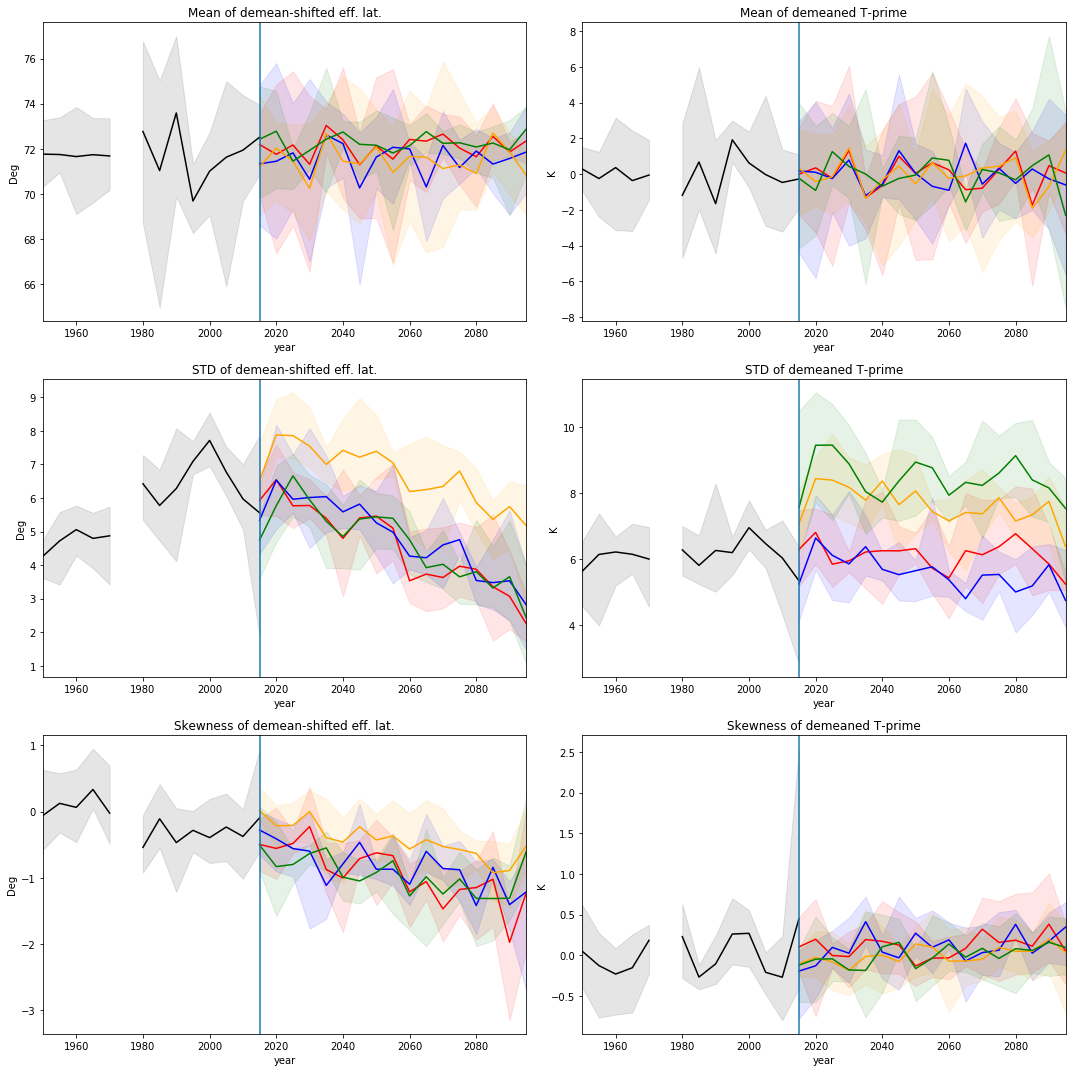

In [74]:
# Greenland
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Greenland','phi_eq_prime','mean',ax1)
ribbon_subplot('Greenland','dm_t_prime','mean',ax2)
ribbon_subplot('Greenland','phi_eq_prime','std',ax3)
ribbon_subplot('Greenland','dm_t_prime','std',ax4)
ribbon_subplot('Greenland','phi_eq_prime','skew',ax5)
ribbon_subplot('Greenland','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

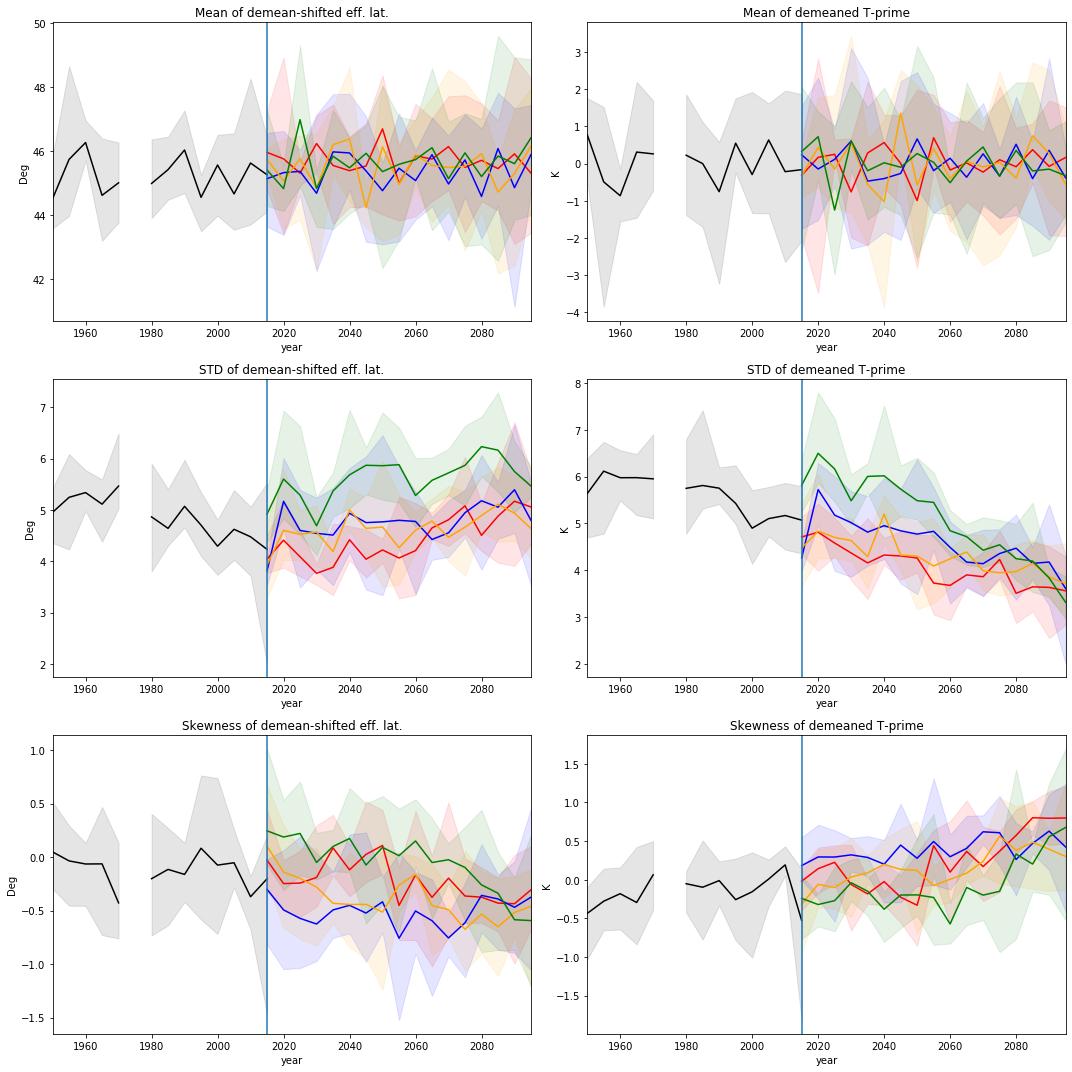

In [75]:
# Maine
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Maine','phi_eq_prime','mean',ax1)
ribbon_subplot('Maine','dm_t_prime','mean',ax2)
ribbon_subplot('Maine','phi_eq_prime','std',ax3)
ribbon_subplot('Maine','dm_t_prime','std',ax4)
ribbon_subplot('Maine','phi_eq_prime','skew',ax5)
ribbon_subplot('Maine','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

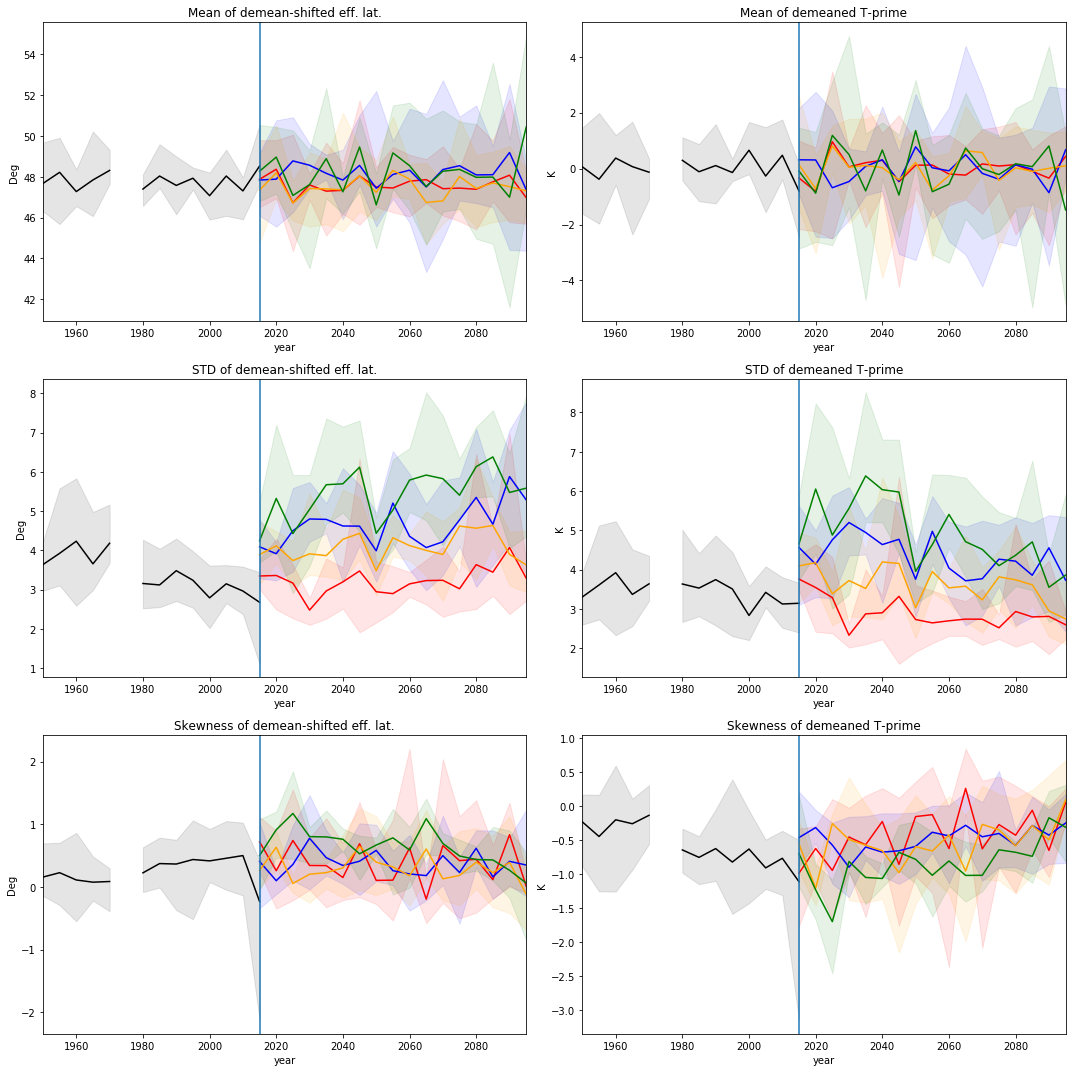

In [76]:
# Washington
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('Washington','phi_eq_prime','mean',ax1)
ribbon_subplot('Washington','dm_t_prime','mean',ax2)
ribbon_subplot('Washington','phi_eq_prime','std',ax3)
ribbon_subplot('Washington','dm_t_prime','std',ax4)
ribbon_subplot('Washington','phi_eq_prime','skew',ax5)
ribbon_subplot('Washington','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

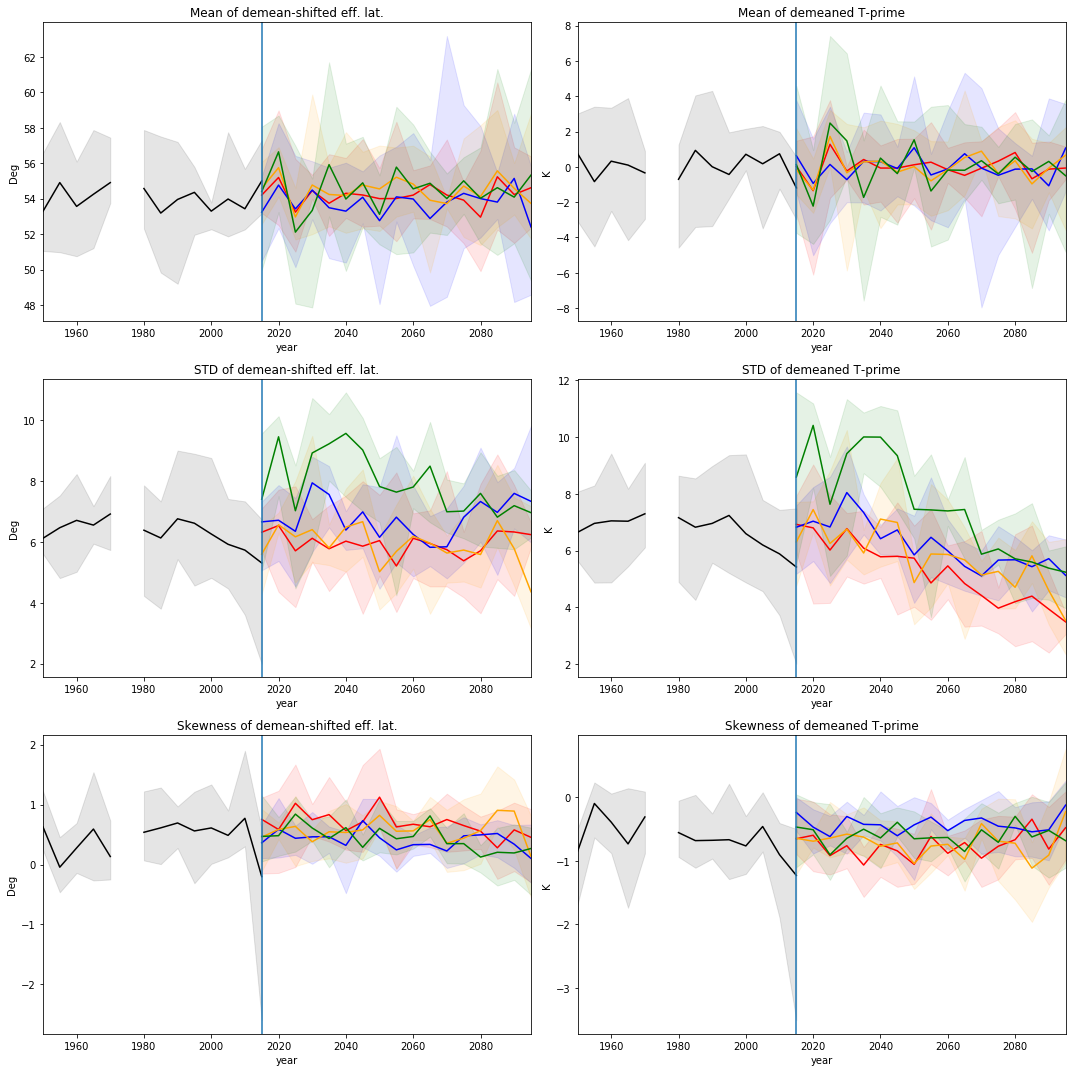

In [77]:
# British Columbia
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(15,15))
ribbon_subplot('British Columbia','phi_eq_prime','mean',ax1)
ribbon_subplot('British Columbia','dm_t_prime','mean',ax2)
ribbon_subplot('British Columbia','phi_eq_prime','std',ax3)
ribbon_subplot('British Columbia','dm_t_prime','std',ax4)
ribbon_subplot('British Columbia','phi_eq_prime','skew',ax5)
ribbon_subplot('British Columbia','dm_t_prime','skew',ax6)
fig.tight_layout()
plt.show()

## Slope Plots

In [78]:
#Reanalysis
# 50-79
def slope_reanalysis1(lonsel,latsel,city):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    dataall=dataall.sel(lon=lon_closest_value)
    latlist=dataall.to_dataframe().reset_index().lat.unique()
    ind=np.where(latlist==lat_closest_value)[0][0]
    
    # read into the raw temperature datas
    dlist=[1950,1955,1960,1965,1970]
    def iswinter(month, day):
        return (month == 1) | (month == 2) | ((month == 12) & (day >= 15))
    for x in dlist:
        print(x)
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1950_1979_lat_20_1D_rename/ds_1950_1979_lat_20_1D_rename_t_prime_'+str(x)+'-12-01_'+str(x+5)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        if x==1950:
            dataall1=select1
            dataall2=select2
        else:
            dataall1=xr.combine_by_coords([dataall1, select1])
            dataall2=xr.combine_by_coords([dataall2, select2])
    
    dataall1 = dataall1.to_dataframe().reset_index()
    dataall2 = dataall2.to_dataframe().reset_index()
    print('data loaded')
    
    # take slopes
    slall = dataall1[['time']]
    ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
    slall['slope']=ent
    slall['year']=slall.time.dt.year
    slall['month']=slall.time.dt.month
    slall['winter']=slall['year']
    mask=slall.month<=3
    slall.loc[mask, 'winter'] = slall['year']-1
    slall['decade']=(np.floor((slall['winter']-1950)/5)+1)*5+1945
    slall.to_csv('/project2/moyer/jetstream/ribbon_files/slope_all_'+city+'_pre1.csv',index=True)
           
    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    sldf=pd.DataFrame(columns = ['decade','mean','min','max'])
    for x in dlist:
        print(x)
        select=slall[year_separator(slall.time.dt.year,slall.time.dt.month,x,x+5)]
        slsum=select[['slope','decade']].groupby(['decade']).agg(['mean','min','max'])
        slsum.columns=slsum.columns.droplevel()
        sldf=sldf.append(slsum, sort=True)
    
    sldf.to_csv('/project2/moyer/jetstream/ribbon_files/slope_sum_'+city+'_pre1.csv',index=True)


In [79]:
# Chicago
slope_reanalysis1(-87.5,42,'Chicago')

closest value
42.0
-87.5
1950
1955
1960
1965
1970
data loaded
1950


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

NameError: name 'year_separator' is not defined

In [8]:
    latsel=42
    lonsel=-87.5
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

MemoryError: Unable to allocate 6.76 GiB for an array with shape (2250, 280, 1440) and data type float64

In [66]:
#Reanalysis
# 79-20
def slope_reanalysis2(lonsel,latsel,city):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    latlist=dataall.to_dataframe().reset_index().lat.unique()
    ind=np.where(latlist==lat_closest_value)[0][0]
    
    # read into the raw temperature datas
    x1list=[1979,1984,1986,1988]
    x2list=[1984,1986,1988,1990]
    def iswinter(month, day):
        return (month == 1) | (month == 2) | ((month == 12) & (day >= 15))
    for i in range(0,4):
        x1=x1list[i]
        x2=x2list[i]
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(x1)+'-12-01_'+str(x2)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        if x1==1979:
            dataall1=select1
            dataall2=select2
        else:
            dataall1=xr.combine_by_coords([dataall1, select1])
            dataall2=xr.combine_by_coords([dataall2, select2])
    
    for y in range(1990,2020):
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(y)+'-12-01_'+str(y+1)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select1=select.sel(lat=data.lat[ind])
        select2=select.sel(lat=data.lat[ind-1])
        select1=select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
        select2=select2.sel(time=iswinter(select2['time.month'], select2['time.day']))
        # concat
        dataall1=xr.combine_by_coords([dataall1, select1])
        dataall2=xr.combine_by_coords([dataall2, select2])
    
    dataall1 = dataall1.to_dataframe().reset_index()
    dataall2 = dataall2.to_dataframe().reset_index()
    print('data loaded')
        
    # take slopes
    slall = dataall1[['time']]
    ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
    slall['slope']=ent
    slall['year']=slall.time.dt.year
    slall['month']=slall.time.dt.month
    slall['winter']=slall['year']
    mask=slall.month<=3
    slall.loc[mask, 'winter'] = slall['year']-1
    slall['decade']=(np.floor((slall['winter']-1980)/5)+1)*5+1975
    slall.to_csv('/project2/moyer/jetstream/ribbon_files/slope_all_'+city+'_pre2.csv',index=True)

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    sldf=pd.DataFrame(columns = ['decade','mean','min','max'])
    for x in dlist:
        print(x)
        select=slall[year_separator(slall.time.dt.year,slall.time.dt.month,x,x+5)]
        slsum=select[['slope','decade']].groupby(['decade']).agg(['mean','min','max'])
        slsum.columns=slsum.columns.droplevel()
        sldf=sldf.append(slsum, sort=True)
    
    sldf.to_csv('/project2/moyer/jetstream/ribbon_files/slope_sum_'+city+'_pre2.csv',index=True)
    

In [3]:
latsel=41
lonsel=-87
dataall=data
print('closest value')
absolute_difference_function = lambda list_value : abs(list_value - given_value)
given_value=latsel
lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
print(lat_closest_value)
given_value=lonsel
lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
print(lon_closest_value)

closest value
41.0
-87.0


In [4]:
latlist=dataall.to_dataframe().reset_index().lat.unique()
ind=np.where(latlist==lat_closest_value)[0][0]

In [5]:
latlist[ind]

41.0

In [32]:
select=data.sel(lon=lon_closest_value)
select1=select.sel(lat=data.lat[ind])
select2=select.sel(lat=data.lat[ind-1])
select1 = select1.sel(time=iswinter(select['time.month'], select['time.day']))
select2 = select2.sel(time=iswinter(select['time.month'], select['time.day']))

In [33]:
dataall1=select1
dataall2=select2

In [34]:
dataall1 = dataall1.to_dataframe().reset_index()
dataall2 = dataall2.to_dataframe().reset_index()

In [35]:
dataall1

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-15,41.0,-87.0,280.967974,268.987366,-11.980608
1,1950-12-16,41.0,-87.0,280.432659,263.348267,-17.084392
2,1950-12-17,41.0,-87.0,280.535757,260.472839,-20.062918
3,1950-12-18,41.0,-87.0,280.617118,256.481781,-24.135337
4,1950-12-19,41.0,-87.0,280.495161,259.526642,-20.968519
...,...,...,...,...,...,...
376,1955-02-24,41.0,-87.0,281.421778,275.178375,-6.243403
377,1955-02-25,41.0,-87.0,281.482596,272.465881,-9.016715
378,1955-02-26,41.0,-87.0,281.537935,279.844879,-1.693056
379,1955-02-27,41.0,-87.0,281.313685,281.137177,-0.176509


In [36]:
dataall2

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-15,41.25,-87.0,280.682446,269.005035,-11.677411
1,1950-12-16,41.25,-87.0,280.183820,263.353088,-16.830731
2,1950-12-17,41.25,-87.0,280.307527,261.860382,-18.447145
3,1950-12-18,41.25,-87.0,280.409046,259.759521,-20.649524
4,1950-12-19,41.25,-87.0,280.261020,259.891693,-20.369327
...,...,...,...,...,...,...
376,1955-02-24,41.25,-87.0,281.184695,275.081818,-6.102877
377,1955-02-25,41.25,-87.0,281.264364,272.160187,-9.104178
378,1955-02-26,41.25,-87.0,281.261620,279.443756,-1.817864
379,1955-02-27,41.25,-87.0,281.053153,280.238129,-0.815025


In [37]:
sldf = dataall1[['time']]
ent=(latlist[ind]-latlist[ind-1])/(dataall1['t_ref']-dataall2['t_ref'])
sldf['slope']=ent

/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
sldf

,time,slope
0,1950-12-15,-0.875572
1,1950-12-16,-1.004665
2,1950-12-17,-1.095383
3,1950-12-18,-1.201508
4,1950-12-19,-1.067733
...,...,...
376,1955-02-24,-1.054482
377,1955-02-25,-1.145573
378,1955-02-26,-0.904762
379,1955-02-27,-0.959576


In [40]:
dataall2

,time,lat,lon,t_ref,t2m,t_prime
0,1950-12-01,41.25,0.0,284.255066,284.255066,0.000000
1,1950-12-02,41.25,0.0,286.171295,286.171295,0.000000
2,1950-12-03,41.25,0.0,287.318665,287.318665,0.000000
3,1950-12-04,41.25,0.0,280.933777,280.933777,0.000000
4,1950-12-05,41.25,0.0,276.122131,276.122131,0.000000
...,...,...,...,...,...,...
446,1955-02-24,41.25,0.0,281.184695,283.939545,2.754850
447,1955-02-25,41.25,0.0,281.264364,282.754578,1.490213
448,1955-02-26,41.25,0.0,281.261620,280.070770,-1.190850
449,1955-02-27,41.25,0.0,281.053153,280.312012,-0.741142


In [52]:
select1=data.sel(lon=70)
select1=select1.sel(lat=41)
select2=data.sel(lon=20)
select2=select2.sel(lat=41)

In [53]:
select1

<xarray.Dataset>
Dimensions:  (time: 451)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1955-02-28
    lat      float32 41.0
    lon      float32 70.0
Data variables:
    t_ref    (time) float64 280.1 281.7 284.8 283.3 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 280.0955 281.6907 284.7526 ... 287.9505 291.61365
    t_prime  (time) float64 0.0 0.0 0.0 0.0 0.0 ... -0.7066 2.924 6.637 10.75

In [54]:
select2

<xarray.Dataset>
Dimensions:  (time: 451)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-01 1950-12-02 ... 1955-02-28
    lat      float32 41.0
    lon      float32 20.0
Data variables:
    t_ref    (time) float64 285.4 286.8 287.4 287.8 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 285.40863 286.78018 287.35593 ... 285.71088 287.354
    t_prime  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 8.766 6.232 4.397 6.492

In [2]:
data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1950_1979_lat_20_1D_rename/ds_1950_1979_lat_20_1D_rename_t_prime_1950-12-01_1955-03-01.nc4')
        

In [43]:
select1=data.sel(lon=70)
select1=select1.sel(lat=41)
select2=data.sel(lon=20)
select2=select2.sel(lat=41)

In [44]:
select1 = select1.sel(time=iswinter(select1['time.month'], select1['time.day']))
select2 = select2.sel(time=iswinter(select2['time.month'], select2['time.day']))

In [47]:
select1

<xarray.Dataset>
Dimensions:  (time: 381)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-15 1950-12-16 ... 1955-02-28
    lat      float32 41.0
    lon      float32 70.0
Data variables:
    t_ref    (time) float64 281.0 280.4 280.5 280.6 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 279.30093 279.19168 278.06436 ... 287.9505 291.61365
    t_prime  (time) float64 -1.667 -1.241 -2.471 -3.386 ... 2.924 6.637 10.75

In [48]:
select2

<xarray.Dataset>
Dimensions:  (time: 381)
Coordinates:
  * time     (time) datetime64[ns] 1950-12-15 1950-12-16 ... 1955-02-28
    lat      float32 41.0
    lon      float32 20.0
Data variables:
    t_ref    (time) float64 281.0 280.4 280.5 280.6 ... 281.5 281.5 281.3 280.9
    t2m      (time) float32 287.06827 285.9714 286.7587 ... 285.71088 287.354
    t_prime  (time) float64 6.1 5.539 6.223 4.328 ... 8.766 6.232 4.397 6.492